In [1]:
import tensorflow as tf
from PIL import Image
from scipy.misc import imread, imshow,imresize
from glob import glob
from itertools import cycle,zip_longest
import numpy as np
import matplotlib.pyplot as plt
import imageio
import random
import os
from tensorflow.contrib import slim
import time
import sys
sys.path.insert(0, '/home/ubuntu/workspace/models/research/slim/')
from nets.resnet_v1 import resnet_v1,resnet_v1_101,resnet_arg_scope
from datasets import dataset_utils

In [2]:
random.seed(42)
tf.set_random_seed(42)

In [3]:
def grouper(n, iterable, fillvalue=None):
  args = [iter(iterable)]*n
  return zip_longest(*args, fillvalue=fillvalue)

In [4]:
height_image = resnet_v1.default_image_size
width_image = resnet_v1.default_image_size
print(height_image)

224


In [5]:
def get_images(data_dir, training, batch_size=10):
  height = height_image
  width = width_image
  if(training == True):
    data_dir = data_dir +"Train/"
  else:
    data_dir = data_dir +"Val/"
  input_files_positive = glob(data_dir + "Positive/*.jpg")
  input_files_negative = glob(data_dir + "Negative/*.jpg")
  input_files_neutral = glob(data_dir + "Neutral/*.jpg")
  #input_files_positive = glob(data_dir + "daisy/*.jpg")
  #input_files_negative = glob(data_dir + "roses/*.jpg")
  #input_files_neutral = glob(data_dir + "tulips/*.jpg")
  input_files = input_files_positive + input_files_negative + input_files_neutral
  labels = [np.array([0,0,1])]*len(input_files_positive) + [np.array([0,1,0])]*len(input_files_negative) + [np.array([1,0,0])]*len(input_files_neutral)
  label_files = list(zip(input_files,labels))
  label_files = random.sample(label_files,len(label_files))
  label_files_infinite = cycle(label_files)

  label_files_grouped = grouper(batch_size,label_files_infinite)
  while 1:
    image_names,labels = zip(*next(label_files_grouped))
    
    #can change image size - note - possibly investigate?
    image_files = [imresize(np.uint8(imageio.imread(fname)),(height,width)) for fname in image_names]
    
    yield zip(image_files,list(labels))


In [6]:
data_dir = "/home/ubuntu/project/data/"

In [7]:
x = get_images(data_dir,True,10)

/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


[1 0 0]
(224, 224, 3)


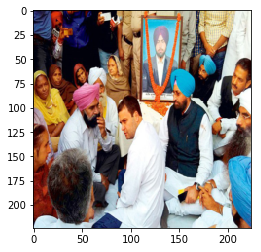

In [8]:
images, labels = map(list, zip(*next(x)))
print(labels[0])
print(images[0].shape)
plt.imshow(images[0])
plt.show()

In [12]:
total_num_images = 3630
num_epochs = 100 #hp 1
batch_size = 50 #hp 2
initial_learning_rate = 0.001 #hp 3
num_epochs_before_decay = 60
learning_rate_decay_iterations = 15 #hp 4
keep_prob_val = 0.9 #hp 5
num_batches_per_epoch = int(total_num_images / batch_size)
num_steps_per_epoch = num_batches_per_epoch 

In [10]:
checkpoints_dir = '/tmp/checkpoints'

In [ ]:
url = "http://download.tensorflow.org/models/resnet_v1_101_2016_08_28.tar.gz"

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

In [13]:
tf.reset_default_graph()

images = tf.placeholder(tf.float32,shape=[None,height_image,width_image,3])
labels = tf.placeholder(tf.float32,shape=[None,3])
learning_rate = tf.placeholder(tf.float32,shape=[])
keep_prob = tf.placeholder(tf.float32,shape=[])

with slim.arg_scope(resnet_arg_scope()):
    #restore resnet101 model
    resnet_logits, _ = resnet_v1_101(images, num_classes=1000, global_pool=True, is_training=True)
    

def feed_dict(batch_size, training, epoch):
  keep_prob_per = keep_prob_val
  lr = initial_learning_rate
  if training == True:
    data = get_images(data_dir,training,batch_size)
    keep_prob_per = keep_prob_val
  elif training == False:
    data = get_images(data_dir,training,batch_size)
    keep_prob_per = 1
  imgs, lbls = map(list, zip(*next(data)))
  if(epoch > num_epochs_before_decay and epoch % learning_rate_decay_iterations == 0):
    lr = 0.001*(10**(-epoch/100))

  return {images: imgs, labels: lbls, learning_rate: lr, keep_prob: keep_prob_per}


#checkpoint_exclude_scopes=["resnet_v1_101/logits"]
checkpoint_exclude_scopes=[]
exclusions = checkpoint_exclude_scopes
#review code!
variables_to_restore = []
for var in slim.get_model_variables():
    excluded = False
    for exclusion in exclusions:
        if var.op.name.startswith(exclusion):
            excluded = True
            break
    if not excluded:
        variables_to_restore.append(var)
#variables_to_restore = slim.get_variables_to_restore(exclude = checkpoint_exclude_scopes)
saver = tf.train.Saver(variables_to_restore)

#introduce dropout for resnet final FC layer
logits_drop = tf.contrib.layers.dropout(resnet_logits, keep_prob)
#introduce final FC layer to map output of resnet 1000 to 3 classes
logits = tf.contrib.layers.fully_connected(logits_drop, 3)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits))
correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = slim.learning.create_train_op(cross_entropy, optimizer)


with tf.Session() as sess:
 
  saver.restore(sess,os.path.join(checkpoints_dir, 'resnet_v1_101.ckpt'))
  sess.run(tf.initialize_all_variables())
  
  total_loss_val = 0
  total_train_accuracy = 0
  total_val_accuracy = 0
  best_accuracy = 0
  avg_training_acc = 0
  avg_val_acc = 0
  start_time_per_epoch = 0
  time_elapsed_eval_per_epoch = 0
  time_elapsed_training_per_epoch = 0
  overall_training_time = 0
  
  overall_training_time = time.time()
  for i in range(num_epochs):
    
    best_acc_file = open('/home/ubuntu/project/L44_Mini_Project/data_dir/accuracy/best_accuracy.txt',"a") 
    all_acc_file = open('/home/ubuntu/project/L44_Mini_Project/data_dir/accuracy/all_accuracy.txt',"a") 
    
    start_time_per_epoch = time.time()
    for j in range(num_batches_per_epoch):
      print("Epoch %s, Batch %s" % (i,j))
      _,training_loss = sess.run([train_op, cross_entropy],feed_dict=feed_dict(batch_size,True,i))
      train_accuracy = accuracy.eval(feed_dict=feed_dict(batch_size,True,i))
      total_loss_val = total_loss_val + training_loss
      total_train_accuracy = total_train_accuracy + train_accuracy
    avg_training_acc = total_train_accuracy/num_batches_per_epoch
    print("--------------------------------------------------------------------")
    print("Epoch %s: training accuracy %s, training loss %s" % (i,avg_training_acc,total_loss_val))
    time_elapsed_training_per_epoch = time.time() - start_time_per_epoch
    for _ in range(num_batches_per_epoch):
      validation_accuracy = accuracy.eval(feed_dict=feed_dict(batch_size,False,i))
      total_val_accuracy = total_val_accuracy + validation_accuracy
    avg_val_acc = total_val_accuracy/num_batches_per_epoch
    print("Epoch %s: validation accuracy %s" % (i,avg_val_acc))
    print("--------------------------------------------------------------------")
    time_elapsed_eval_per_epoch = time.time() - start_time_per_epoch - time_elapsed_training_per_epoch
    all_acc_file.write("%s %s %s %s %s %s\n" % (i, total_loss_val, avg_training_acc, avg_val_acc, time_elapsed_training_per_epoch, time_elapsed_eval_per_epoch))
   
    #store model at best accuracy
    if avg_val_acc > best_accuracy:
      best_acc_file.write("Epoch %s: " % (i))
      best_acc_file.write("Best validation accuracy: %s\n" % (avg_val_acc))
      best_accuracy = avg_val_acc
      best_model_path = saver.save(sess, '/home/ubuntu/project/L44_Mini_Project/data_dir/best_model/')  
    
    total_loss_val = 0
    total_train_accuracy = 0
    total_val_accuracy = 0
    avg_training_acc = 0
    avg_val_acc = 0
    best_model_path = ""
    start_time = 0
    time_elapsed_eval = 0
    time_elapsed_training = 0
    
    best_acc_file.close()
    all_acc_file.close()
    
  overall_training_time = time.time() - overall_training_time
  print("Training time: %s" % overall_training_time)
  
      
  #features = graph.get_tensor_by_name('inception_v3/GlobalPool')
  #features_values = sess.run(features)
  #print (features_values[0])
    

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch 0, Batch 0


/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Epoch 0, Batch 1
Epoch 0, Batch 2
Epoch 0, Batch 3
Epoch 0, Batch 4
Epoch 0, Batch 5
Epoch 0, Batch 6
Epoch 0, Batch 7
Epoch 0, Batch 8
Epoch 0, Batch 9
Epoch 0, Batch 10
Epoch 0, Batch 11
Epoch 0, Batch 12


/home/ubuntu/.local/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch 0, Batch 13
Epoch 0, Batch 14
Epoch 0, Batch 15
Epoch 0, Batch 16
Epoch 0, Batch 17
Epoch 0, Batch 18
Epoch 0, Batch 19
Epoch 0, Batch 20
Epoch 0, Batch 21
Epoch 0, Batch 22
Epoch 0, Batch 23
Epoch 0, Batch 24
Epoch 0, Batch 25
Epoch 0, Batch 26
Epoch 0, Batch 27
Epoch 0, Batch 28
Epoch 0, Batch 29
Epoch 0, Batch 30
Epoch 0, Batch 31
Epoch 0, Batch 32
Epoch 0, Batch 33
Epoch 0, Batch 34
Epoch 0, Batch 35
Epoch 0, Batch 36
Epoch 0, Batch 37
Epoch 0, Batch 38
Epoch 0, Batch 39
Epoch 0, Batch 40
Epoch 0, Batch 41
Epoch 0, Batch 42
Epoch 0, Batch 43
Epoch 0, Batch 44
Epoch 0, Batch 45
Epoch 0, Batch 46
Epoch 0, Batch 47
Epoch 0, Batch 48
Epoch 0, Batch 49
Epoch 0, Batch 50
Epoch 0, Batch 51
Epoch 0, Batch 52
Epoch 0, Batch 53
Epoch 0, Batch 54
Epoch 0, Batch 55
Epoch 0, Batch 56
Epoch 0, Batch 57
Epoch 0, Batch 58
Epoch 0, Batch 59
Epoch 0, Batch 60
Epoch 0, Batch 61
Epoch 0, Batch 62
Epoch 0, Batch 63
Epoch 0, Batch 64
Epoch 0, Batch 65
Epoch 0, Batch 66
Epoch 0, Batch 67
Epoch 0, B